
# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

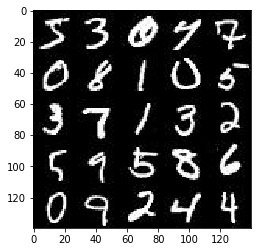

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

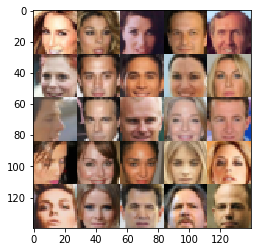

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name = 'inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse) :

        x = tf.layers.conv2d(images, 64, 5, 2, 'same',use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 14X14X64

        x = tf.layers.conv2d(x, 128, 5, 2, 'same',use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 7X7X128

        x = tf.reshape(x,(-1,7*7*128))
        logits = tf.layers.dense(x,1)
        out = tf.sigmoid(logits)

    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train) :

        x = tf.layers.dense(z,7*7*256)
        x = tf.reshape(x,(-1,7,7,256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d_transpose(x,128, 5, 1,padding='same',use_bias=False)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7X7X128

        x = tf.layers.conv2d_transpose(x,64, 5, 2,padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 14X14X64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5,2, padding='same',use_bias=False)
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [50]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_logits_real, d_model_real = discriminator(input_real)
    d_logits_fake, d_model_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))

    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_fake + d_loss_real

    g_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [54]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [56]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    samples, losses = [], []
    sample = np.random.uniform(-1,1, size=(25,z_dim))
    print_every = 10
    steps = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                # sample batch for G
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:

                    train_loss_d = d_loss.eval({input_real:batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z: batch_z, lr: learning_rate})

                    print('Epoch {}/{}...'.format(epoch_i+1, epoch_count),
                          'Discriminator_loss: {}'.format(train_loss_d),
                          'Generator_loss: {}'.format(train_loss_g))
                    losses.append((train_loss_d,train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, tf.convert_to_tensor(sample, dtype=tf.float32) , len(data_image_mode), data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
                


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator_loss: 0.31555065512657166 Generator_loss: 1.769087314605713
Epoch 1/2... Discriminator_loss: 0.5934640765190125 Generator_loss: 1.0365428924560547
Epoch 1/2... Discriminator_loss: 0.46760332584381104 Generator_loss: 2.557983160018921
Epoch 1/2... Discriminator_loss: 1.3900353908538818 Generator_loss: 0.6696162819862366
Epoch 1/2... Discriminator_loss: 0.7497222423553467 Generator_loss: 1.261354684829712
Epoch 1/2... Discriminator_loss: 0.8795046806335449 Generator_loss: 1.7513084411621094
Epoch 1/2... Discriminator_loss: 0.8642159700393677 Generator_loss: 2.269644260406494
Epoch 1/2... Discriminator_loss: 1.8668113946914673 Generator_loss: 2.3934295177459717
Epoch 1/2... Discriminator_loss: 1.3584928512573242 Generator_loss: 0.9111893177032471
Epoch 1/2... Discriminator_loss: 1.3602954149246216 Generator_loss: 0.5089797973632812


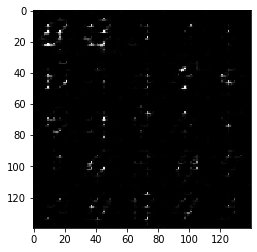

Epoch 1/2... Discriminator_loss: 1.3393614292144775 Generator_loss: 0.4455086886882782
Epoch 1/2... Discriminator_loss: 1.1024457216262817 Generator_loss: 1.8721671104431152
Epoch 1/2... Discriminator_loss: 1.480924367904663 Generator_loss: 2.496941566467285
Epoch 1/2... Discriminator_loss: 1.313245177268982 Generator_loss: 2.8493216037750244
Epoch 1/2... Discriminator_loss: 1.2995202541351318 Generator_loss: 4.466804504394531
Epoch 1/2... Discriminator_loss: 0.3747701942920685 Generator_loss: 2.559580087661743
Epoch 1/2... Discriminator_loss: 2.577575206756592 Generator_loss: 0.11078247427940369
Epoch 1/2... Discriminator_loss: 0.31462642550468445 Generator_loss: 2.2428646087646484
Epoch 1/2... Discriminator_loss: 0.3472749590873718 Generator_loss: 1.4815709590911865
Epoch 1/2... Discriminator_loss: 1.6390306949615479 Generator_loss: 5.216030120849609


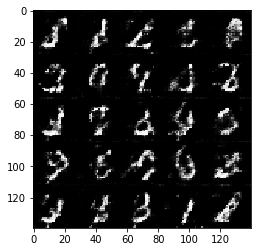

Epoch 1/2... Discriminator_loss: 0.20891255140304565 Generator_loss: 2.9355266094207764
Epoch 1/2... Discriminator_loss: 0.18447557091712952 Generator_loss: 3.061868667602539
Epoch 1/2... Discriminator_loss: 5.487969875335693 Generator_loss: 0.007600442972034216
Epoch 1/2... Discriminator_loss: 0.16816696524620056 Generator_loss: 2.3865959644317627
Epoch 1/2... Discriminator_loss: 0.051625873893499374 Generator_loss: 4.057940483093262
Epoch 1/2... Discriminator_loss: 0.06282053887844086 Generator_loss: 3.635209321975708
Epoch 1/2... Discriminator_loss: 0.0687071904540062 Generator_loss: 3.4407920837402344
Epoch 1/2... Discriminator_loss: 0.04209990054368973 Generator_loss: 3.8728256225585938
Epoch 1/2... Discriminator_loss: 0.023628339171409607 Generator_loss: 4.30674934387207
Epoch 1/2... Discriminator_loss: 0.02681068889796734 Generator_loss: 4.2285990715026855


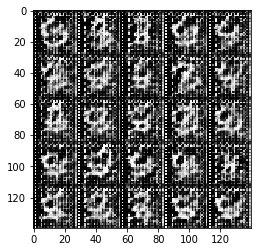

Epoch 1/2... Discriminator_loss: 0.019039515405893326 Generator_loss: 4.457446098327637
Epoch 1/2... Discriminator_loss: 0.06703266501426697 Generator_loss: 3.133101463317871
Epoch 1/2... Discriminator_loss: 0.032454658299684525 Generator_loss: 3.9948253631591797
Epoch 1/2... Discriminator_loss: 0.023544754832983017 Generator_loss: 4.175419330596924
Epoch 1/2... Discriminator_loss: 0.03660627827048302 Generator_loss: 3.8740599155426025
Epoch 1/2... Discriminator_loss: 0.4055074453353882 Generator_loss: 3.3245725631713867
Epoch 1/2... Discriminator_loss: 2.366969347000122 Generator_loss: 2.264420509338379
Epoch 1/2... Discriminator_loss: 1.2779604196548462 Generator_loss: 1.0957531929016113
Epoch 1/2... Discriminator_loss: 0.9302933812141418 Generator_loss: 0.9076517820358276
Epoch 1/2... Discriminator_loss: 0.865271806716919 Generator_loss: 1.577242136001587


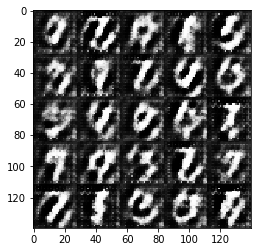

Epoch 1/2... Discriminator_loss: 0.7222351431846619 Generator_loss: 1.2257497310638428
Epoch 1/2... Discriminator_loss: 3.532100200653076 Generator_loss: 0.05221854895353317
Epoch 1/2... Discriminator_loss: 0.6668003797531128 Generator_loss: 2.262346029281616
Epoch 1/2... Discriminator_loss: 0.766822338104248 Generator_loss: 2.2388062477111816
Epoch 1/2... Discriminator_loss: 0.4306284487247467 Generator_loss: 1.7867021560668945
Epoch 1/2... Discriminator_loss: 0.2585991621017456 Generator_loss: 2.2458510398864746
Epoch 1/2... Discriminator_loss: 0.47272181510925293 Generator_loss: 1.3396220207214355
Epoch 1/2... Discriminator_loss: 0.27167266607284546 Generator_loss: 1.823527455329895
Epoch 1/2... Discriminator_loss: 0.10299374163150787 Generator_loss: 3.2428550720214844
Epoch 1/2... Discriminator_loss: 0.13391904532909393 Generator_loss: 2.418332576751709


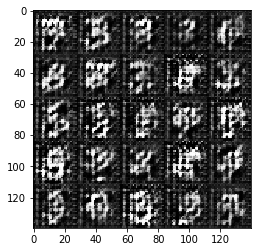

Epoch 1/2... Discriminator_loss: 1.7263426780700684 Generator_loss: 0.2960283160209656
Epoch 1/2... Discriminator_loss: 1.897205114364624 Generator_loss: 0.21670667827129364
Epoch 1/2... Discriminator_loss: 0.5868972539901733 Generator_loss: 1.3436696529388428
Epoch 1/2... Discriminator_loss: 0.44831159710884094 Generator_loss: 3.3054518699645996
Epoch 1/2... Discriminator_loss: 0.9704384207725525 Generator_loss: 0.9529346227645874
Epoch 1/2... Discriminator_loss: 1.3894402980804443 Generator_loss: 0.5003713369369507
Epoch 1/2... Discriminator_loss: 1.301198959350586 Generator_loss: 0.534132719039917
Epoch 1/2... Discriminator_loss: 1.3531396389007568 Generator_loss: 0.4503653049468994
Epoch 1/2... Discriminator_loss: 0.3066204786300659 Generator_loss: 2.6098945140838623
Epoch 1/2... Discriminator_loss: 0.497211217880249 Generator_loss: 1.3079590797424316


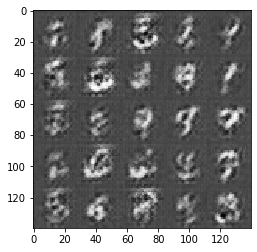

Epoch 1/2... Discriminator_loss: 0.6461293697357178 Generator_loss: 1.498267650604248
Epoch 1/2... Discriminator_loss: 1.4022901058197021 Generator_loss: 2.5879604816436768
Epoch 1/2... Discriminator_loss: 1.2413139343261719 Generator_loss: 3.383694648742676
Epoch 1/2... Discriminator_loss: 0.5777696371078491 Generator_loss: 1.1308090686798096
Epoch 1/2... Discriminator_loss: 0.5462446212768555 Generator_loss: 1.8237159252166748
Epoch 1/2... Discriminator_loss: 0.833480954170227 Generator_loss: 0.7197737693786621
Epoch 1/2... Discriminator_loss: 1.567489743232727 Generator_loss: 2.9420323371887207
Epoch 1/2... Discriminator_loss: 0.6811222434043884 Generator_loss: 1.0419400930404663
Epoch 1/2... Discriminator_loss: 0.41107410192489624 Generator_loss: 1.6094069480895996
Epoch 1/2... Discriminator_loss: 0.40423834323883057 Generator_loss: 1.712174892425537


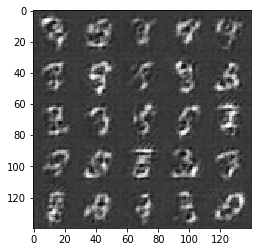

Epoch 1/2... Discriminator_loss: 0.3664394021034241 Generator_loss: 1.9098179340362549
Epoch 1/2... Discriminator_loss: 1.0319979190826416 Generator_loss: 0.9240875244140625
Epoch 1/2... Discriminator_loss: 0.9790300130844116 Generator_loss: 0.7676703929901123
Epoch 1/2... Discriminator_loss: 1.3045341968536377 Generator_loss: 0.3869692087173462
Epoch 1/2... Discriminator_loss: 1.1630488634109497 Generator_loss: 0.5211840867996216
Epoch 1/2... Discriminator_loss: 0.6162189245223999 Generator_loss: 1.004465937614441
Epoch 1/2... Discriminator_loss: 0.33938223123550415 Generator_loss: 2.11806058883667
Epoch 1/2... Discriminator_loss: 0.5715627670288086 Generator_loss: 1.4246190786361694
Epoch 1/2... Discriminator_loss: 1.3719961643218994 Generator_loss: 0.3562445044517517
Epoch 1/2... Discriminator_loss: 0.713535726070404 Generator_loss: 2.673527717590332


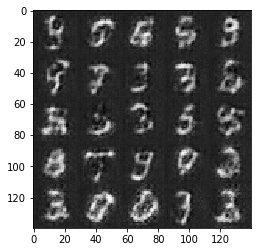

Epoch 1/2... Discriminator_loss: 0.20599156618118286 Generator_loss: 2.405778408050537
Epoch 1/2... Discriminator_loss: 1.3083724975585938 Generator_loss: 0.42903369665145874
Epoch 1/2... Discriminator_loss: 0.3029650151729584 Generator_loss: 1.8735065460205078
Epoch 1/2... Discriminator_loss: 0.35393279790878296 Generator_loss: 1.5304746627807617
Epoch 1/2... Discriminator_loss: 0.4123765230178833 Generator_loss: 1.3531982898712158
Epoch 1/2... Discriminator_loss: 3.4528486728668213 Generator_loss: 4.05027961730957
Epoch 1/2... Discriminator_loss: 1.4381227493286133 Generator_loss: 1.2472907304763794
Epoch 1/2... Discriminator_loss: 1.5142003297805786 Generator_loss: 1.392458200454712
Epoch 1/2... Discriminator_loss: 1.2979485988616943 Generator_loss: 1.9323900938034058
Epoch 1/2... Discriminator_loss: 1.0016236305236816 Generator_loss: 1.3029356002807617


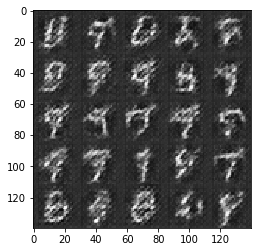

Epoch 1/2... Discriminator_loss: 0.7747207283973694 Generator_loss: 1.2123265266418457
Epoch 1/2... Discriminator_loss: 0.9004563093185425 Generator_loss: 0.9215888977050781
Epoch 1/2... Discriminator_loss: 1.2607817649841309 Generator_loss: 0.4554710388183594
Epoch 2/2... Discriminator_loss: 1.4169063568115234 Generator_loss: 0.3592418432235718
Epoch 2/2... Discriminator_loss: 0.841619074344635 Generator_loss: 1.051588535308838
Epoch 2/2... Discriminator_loss: 0.6841849088668823 Generator_loss: 1.1136500835418701
Epoch 2/2... Discriminator_loss: 1.4992702007293701 Generator_loss: 2.699054479598999
Epoch 2/2... Discriminator_loss: 0.8177900314331055 Generator_loss: 1.4517090320587158
Epoch 2/2... Discriminator_loss: 1.1290385723114014 Generator_loss: 0.5199375748634338
Epoch 2/2... Discriminator_loss: 1.3483598232269287 Generator_loss: 0.3719894289970398


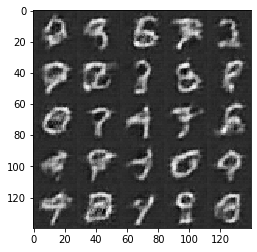

Epoch 2/2... Discriminator_loss: 1.070907473564148 Generator_loss: 0.50989830493927
Epoch 2/2... Discriminator_loss: 0.4900380074977875 Generator_loss: 1.817046046257019
Epoch 2/2... Discriminator_loss: 1.1558547019958496 Generator_loss: 2.341334342956543
Epoch 2/2... Discriminator_loss: 0.590722918510437 Generator_loss: 1.7467944622039795
Epoch 2/2... Discriminator_loss: 0.7259295582771301 Generator_loss: 2.38601016998291
Epoch 2/2... Discriminator_loss: 1.7997043132781982 Generator_loss: 0.2338303029537201
Epoch 2/2... Discriminator_loss: 0.775294303894043 Generator_loss: 1.1851534843444824
Epoch 2/2... Discriminator_loss: 0.8343034982681274 Generator_loss: 0.7799099683761597
Epoch 2/2... Discriminator_loss: 0.5045719146728516 Generator_loss: 1.5054128170013428
Epoch 2/2... Discriminator_loss: 1.6518542766571045 Generator_loss: 0.24620740115642548


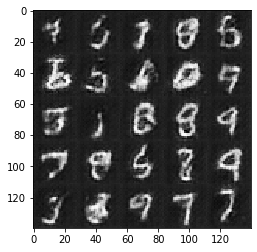

Epoch 2/2... Discriminator_loss: 0.797500491142273 Generator_loss: 1.565479040145874
Epoch 2/2... Discriminator_loss: 0.7744313478469849 Generator_loss: 1.4823012351989746
Epoch 2/2... Discriminator_loss: 0.9763302803039551 Generator_loss: 2.6680355072021484
Epoch 2/2... Discriminator_loss: 0.43341219425201416 Generator_loss: 1.5313432216644287
Epoch 2/2... Discriminator_loss: 0.7890892028808594 Generator_loss: 1.4336252212524414
Epoch 2/2... Discriminator_loss: 1.7692919969558716 Generator_loss: 0.2308957874774933
Epoch 2/2... Discriminator_loss: 1.1209970712661743 Generator_loss: 0.521308422088623
Epoch 2/2... Discriminator_loss: 0.3028470277786255 Generator_loss: 1.937034249305725
Epoch 2/2... Discriminator_loss: 0.7009293437004089 Generator_loss: 0.9256649613380432
Epoch 2/2... Discriminator_loss: 0.3215804398059845 Generator_loss: 1.638547420501709


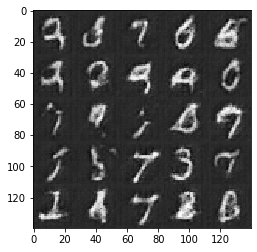

Epoch 2/2... Discriminator_loss: 1.369240164756775 Generator_loss: 2.4640896320343018
Epoch 2/2... Discriminator_loss: 1.0612022876739502 Generator_loss: 0.6735678911209106
Epoch 2/2... Discriminator_loss: 1.200079321861267 Generator_loss: 0.5211785435676575
Epoch 2/2... Discriminator_loss: 0.7822061777114868 Generator_loss: 0.82042396068573
Epoch 2/2... Discriminator_loss: 0.8158348798751831 Generator_loss: 3.353081703186035
Epoch 2/2... Discriminator_loss: 0.5433789491653442 Generator_loss: 1.179521083831787
Epoch 2/2... Discriminator_loss: 1.241692304611206 Generator_loss: 0.4970725178718567
Epoch 2/2... Discriminator_loss: 1.2030174732208252 Generator_loss: 1.6555289030075073
Epoch 2/2... Discriminator_loss: 0.9383251070976257 Generator_loss: 2.78592848777771
Epoch 2/2... Discriminator_loss: 1.4136922359466553 Generator_loss: 3.7497239112854004


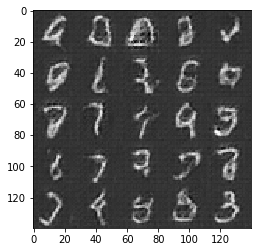

Epoch 2/2... Discriminator_loss: 0.5192296504974365 Generator_loss: 1.2049853801727295
Epoch 2/2... Discriminator_loss: 0.5221322774887085 Generator_loss: 2.140007495880127
Epoch 2/2... Discriminator_loss: 1.3322638273239136 Generator_loss: 2.548649549484253
Epoch 2/2... Discriminator_loss: 0.9412460327148438 Generator_loss: 1.6929104328155518
Epoch 2/2... Discriminator_loss: 0.9383349418640137 Generator_loss: 1.7291173934936523
Epoch 2/2... Discriminator_loss: 0.9898510575294495 Generator_loss: 0.5750554203987122
Epoch 2/2... Discriminator_loss: 0.5671762228012085 Generator_loss: 1.1104447841644287
Epoch 2/2... Discriminator_loss: 0.5022326707839966 Generator_loss: 1.9093024730682373
Epoch 2/2... Discriminator_loss: 0.2981114387512207 Generator_loss: 2.2244138717651367
Epoch 2/2... Discriminator_loss: 1.1375629901885986 Generator_loss: 1.615425705909729


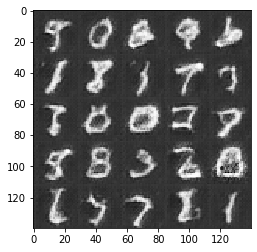

Epoch 2/2... Discriminator_loss: 1.073206901550293 Generator_loss: 0.5980947613716125
Epoch 2/2... Discriminator_loss: 0.989251434803009 Generator_loss: 1.1617861986160278
Epoch 2/2... Discriminator_loss: 0.7389464974403381 Generator_loss: 1.9740684032440186
Epoch 2/2... Discriminator_loss: 0.5428762435913086 Generator_loss: 1.2876158952713013
Epoch 2/2... Discriminator_loss: 0.803204357624054 Generator_loss: 0.7747248411178589
Epoch 2/2... Discriminator_loss: 0.3735845685005188 Generator_loss: 1.811067819595337
Epoch 2/2... Discriminator_loss: 1.0558793544769287 Generator_loss: 0.5623081922531128
Epoch 2/2... Discriminator_loss: 0.8158303499221802 Generator_loss: 1.969955563545227
Epoch 2/2... Discriminator_loss: 0.23400577902793884 Generator_loss: 2.250617027282715
Epoch 2/2... Discriminator_loss: 0.27132338285446167 Generator_loss: 1.7834069728851318


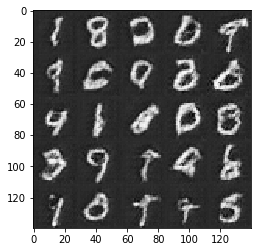

Epoch 2/2... Discriminator_loss: 1.1485015153884888 Generator_loss: 0.5694962739944458
Epoch 2/2... Discriminator_loss: 0.8522595167160034 Generator_loss: 1.7198671102523804
Epoch 2/2... Discriminator_loss: 0.5339193344116211 Generator_loss: 1.3318837881088257
Epoch 2/2... Discriminator_loss: 0.3974422514438629 Generator_loss: 1.4827585220336914
Epoch 2/2... Discriminator_loss: 0.6234809160232544 Generator_loss: 5.226971626281738
Epoch 2/2... Discriminator_loss: 2.515388011932373 Generator_loss: 4.762152671813965
Epoch 2/2... Discriminator_loss: 0.6176584362983704 Generator_loss: 1.7148540019989014
Epoch 2/2... Discriminator_loss: 0.7654561996459961 Generator_loss: 1.0190584659576416
Epoch 2/2... Discriminator_loss: 0.7038430571556091 Generator_loss: 0.9118952751159668
Epoch 2/2... Discriminator_loss: 0.9242511987686157 Generator_loss: 1.8201634883880615


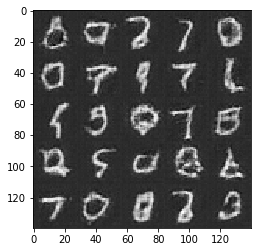

Epoch 2/2... Discriminator_loss: 0.7090135812759399 Generator_loss: 1.380552053451538
Epoch 2/2... Discriminator_loss: 1.7641041278839111 Generator_loss: 2.794994354248047
Epoch 2/2... Discriminator_loss: 0.6512220501899719 Generator_loss: 1.0453290939331055
Epoch 2/2... Discriminator_loss: 2.096648931503296 Generator_loss: 3.435824394226074
Epoch 2/2... Discriminator_loss: 0.7513401508331299 Generator_loss: 0.9448040723800659
Epoch 2/2... Discriminator_loss: 0.723444938659668 Generator_loss: 1.3558719158172607
Epoch 2/2... Discriminator_loss: 0.36959701776504517 Generator_loss: 1.6628007888793945
Epoch 2/2... Discriminator_loss: 0.14139103889465332 Generator_loss: 3.670379400253296
Epoch 2/2... Discriminator_loss: 0.18996435403823853 Generator_loss: 2.365504741668701
Epoch 2/2... Discriminator_loss: 0.34754645824432373 Generator_loss: 1.4551249742507935


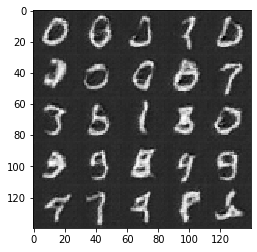

Epoch 2/2... Discriminator_loss: 3.074239492416382 Generator_loss: 0.06979286670684814
Epoch 2/2... Discriminator_loss: 0.6109219193458557 Generator_loss: 1.1508281230926514
Epoch 2/2... Discriminator_loss: 0.529650092124939 Generator_loss: 1.4433650970458984
Epoch 2/2... Discriminator_loss: 1.1208223104476929 Generator_loss: 0.5499918460845947
Epoch 2/2... Discriminator_loss: 0.9200267195701599 Generator_loss: 2.39213490486145
Epoch 2/2... Discriminator_loss: 0.8127310276031494 Generator_loss: 1.1106921434402466
Epoch 2/2... Discriminator_loss: 0.5060398578643799 Generator_loss: 4.320737361907959
Epoch 2/2... Discriminator_loss: 1.4348617792129517 Generator_loss: 0.3604339063167572
Epoch 2/2... Discriminator_loss: 0.5992591381072998 Generator_loss: 1.2687184810638428
Epoch 2/2... Discriminator_loss: 0.9227956533432007 Generator_loss: 0.8132646083831787


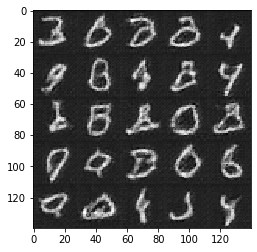

Epoch 2/2... Discriminator_loss: 1.5489329099655151 Generator_loss: 0.3514736294746399
Epoch 2/2... Discriminator_loss: 0.8540574312210083 Generator_loss: 1.9414870738983154
Epoch 2/2... Discriminator_loss: 0.4981275498867035 Generator_loss: 1.4426567554473877
Epoch 2/2... Discriminator_loss: 0.5264542102813721 Generator_loss: 1.3216774463653564
Epoch 2/2... Discriminator_loss: 1.2203363180160522 Generator_loss: 3.273822069168091
Epoch 2/2... Discriminator_loss: 0.3794640600681305 Generator_loss: 2.026262044906616
Epoch 2/2... Discriminator_loss: 0.42640405893325806 Generator_loss: 1.5553569793701172


In [57]:
batch_size = 64
z_dim = 100
learning_rate = 0.0015
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator_loss: 0.02304585464298725 Generator_loss: 4.332238674163818
Epoch 1/1... Discriminator_loss: 0.00025524309603497386 Generator_loss: 13.245768547058105
Epoch 1/1... Discriminator_loss: 0.0016984011745080352 Generator_loss: 21.42169952392578
Epoch 1/1... Discriminator_loss: 0.004222833085805178 Generator_loss: 25.350116729736328
Epoch 1/1... Discriminator_loss: 0.030286699533462524 Generator_loss: 17.55315399169922
Epoch 1/1... Discriminator_loss: 0.0297909714281559 Generator_loss: 4.654350280761719
Epoch 1/1... Discriminator_loss: 0.0073790717869997025 Generator_loss: 6.084096908569336
Epoch 1/1... Discriminator_loss: 0.0080373240634799 Generator_loss: 5.346156120300293
Epoch 1/1... Discriminator_loss: 0.012582440860569477 Generator_loss: 8.900677680969238
Epoch 1/1... Discriminator_loss: 0.010326322168111801 Generator_loss: 5.342813491821289


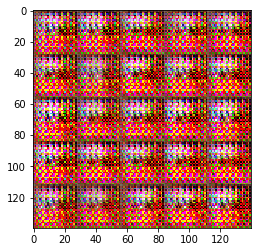

Epoch 1/1... Discriminator_loss: 0.015347521752119064 Generator_loss: 5.289424896240234
Epoch 1/1... Discriminator_loss: 0.007891638204455376 Generator_loss: 5.84168815612793
Epoch 1/1... Discriminator_loss: 0.0037237529177218676 Generator_loss: 6.5500640869140625
Epoch 1/1... Discriminator_loss: 0.004463041201233864 Generator_loss: 6.30280065536499
Epoch 1/1... Discriminator_loss: 0.008374023251235485 Generator_loss: 5.8631157875061035
Epoch 1/1... Discriminator_loss: 0.0026459149084985256 Generator_loss: 6.3130903244018555
Epoch 1/1... Discriminator_loss: 0.0028545965906232595 Generator_loss: 6.597063064575195
Epoch 1/1... Discriminator_loss: 0.0019023725762963295 Generator_loss: 6.5788092613220215
Epoch 1/1... Discriminator_loss: 0.004223868250846863 Generator_loss: 6.435173988342285
Epoch 1/1... Discriminator_loss: 0.00023068436712492257 Generator_loss: 14.760934829711914


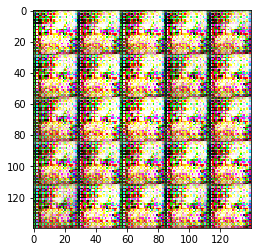

Epoch 1/1... Discriminator_loss: 0.006545941345393658 Generator_loss: 5.514440536499023
Epoch 1/1... Discriminator_loss: 0.0030696126632392406 Generator_loss: 6.16077995300293
Epoch 1/1... Discriminator_loss: 0.003521245438605547 Generator_loss: 6.2821736335754395
Epoch 1/1... Discriminator_loss: 0.0016582650132477283 Generator_loss: 6.7526960372924805
Epoch 1/1... Discriminator_loss: 0.0020193278323858976 Generator_loss: 6.713509559631348
Epoch 1/1... Discriminator_loss: 0.0007846799562685192 Generator_loss: 7.4951887130737305
Epoch 1/1... Discriminator_loss: 0.0031981479842215776 Generator_loss: 6.490705966949463
Epoch 1/1... Discriminator_loss: 0.0029590227641165257 Generator_loss: 6.761254787445068
Epoch 1/1... Discriminator_loss: 0.003381769172847271 Generator_loss: 6.438976287841797
Epoch 1/1... Discriminator_loss: 0.38820508122444153 Generator_loss: 4.511238098144531


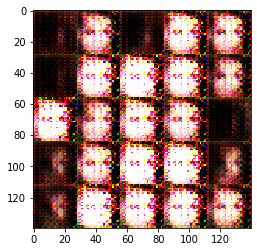

Epoch 1/1... Discriminator_loss: 0.11570526659488678 Generator_loss: 3.349738121032715
Epoch 1/1... Discriminator_loss: 0.10134489089250565 Generator_loss: 3.1389269828796387
Epoch 1/1... Discriminator_loss: 0.08537350594997406 Generator_loss: 3.0827648639678955
Epoch 1/1... Discriminator_loss: 0.029707014560699463 Generator_loss: 4.508146286010742
Epoch 1/1... Discriminator_loss: 0.02511150948703289 Generator_loss: 4.081924915313721
Epoch 1/1... Discriminator_loss: 0.022553825750947 Generator_loss: 4.797478675842285
Epoch 1/1... Discriminator_loss: 0.013888243585824966 Generator_loss: 10.147294998168945
Epoch 1/1... Discriminator_loss: 0.03149879351258278 Generator_loss: 4.433931827545166
Epoch 1/1... Discriminator_loss: 0.011048897169530392 Generator_loss: 5.221556663513184
Epoch 1/1... Discriminator_loss: 0.005035492591559887 Generator_loss: 5.738921165466309


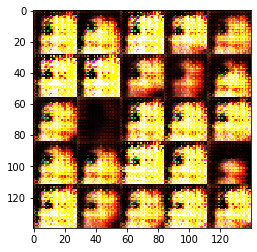

Epoch 1/1... Discriminator_loss: 0.029747873544692993 Generator_loss: 5.963188648223877
Epoch 1/1... Discriminator_loss: 0.007468399591743946 Generator_loss: 5.757571220397949
Epoch 1/1... Discriminator_loss: 0.007486387155950069 Generator_loss: 5.5133514404296875
Epoch 1/1... Discriminator_loss: 0.005261803045868874 Generator_loss: 6.070619583129883
Epoch 1/1... Discriminator_loss: 0.009103055112063885 Generator_loss: 5.464770317077637
Epoch 1/1... Discriminator_loss: 0.007679380010813475 Generator_loss: 5.6293253898620605
Epoch 1/1... Discriminator_loss: 0.00739690288901329 Generator_loss: 5.403244972229004
Epoch 1/1... Discriminator_loss: 0.007769382558763027 Generator_loss: 6.288414001464844
Epoch 1/1... Discriminator_loss: 0.007531065959483385 Generator_loss: 5.861418724060059
Epoch 1/1... Discriminator_loss: 0.006780445575714111 Generator_loss: 5.9021897315979


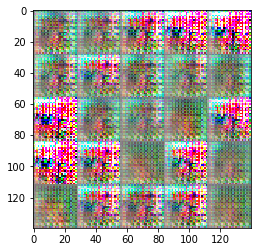

Epoch 1/1... Discriminator_loss: 0.004555255640298128 Generator_loss: 5.969120025634766
Epoch 1/1... Discriminator_loss: 0.0060517205856740475 Generator_loss: 5.322828769683838
Epoch 1/1... Discriminator_loss: 0.01567331701517105 Generator_loss: 5.357468605041504
Epoch 1/1... Discriminator_loss: 0.006844209972769022 Generator_loss: 6.701028823852539
Epoch 1/1... Discriminator_loss: 0.003941047936677933 Generator_loss: 6.850994110107422
Epoch 1/1... Discriminator_loss: 0.01039697602391243 Generator_loss: 5.668025016784668
Epoch 1/1... Discriminator_loss: 0.003197635989636183 Generator_loss: 6.125574111938477
Epoch 1/1... Discriminator_loss: 0.005022692959755659 Generator_loss: 5.735752105712891
Epoch 1/1... Discriminator_loss: 0.004149165470153093 Generator_loss: 6.326655387878418
Epoch 1/1... Discriminator_loss: 0.3209627866744995 Generator_loss: 3.323286771774292


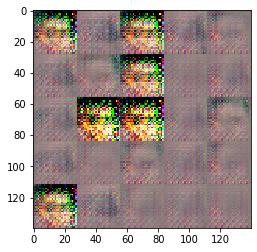

Epoch 1/1... Discriminator_loss: 0.13478954136371613 Generator_loss: 2.891947031021118
Epoch 1/1... Discriminator_loss: 0.08372293412685394 Generator_loss: 3.220907211303711
Epoch 1/1... Discriminator_loss: 0.044679924845695496 Generator_loss: 3.884834051132202
Epoch 1/1... Discriminator_loss: 0.04020008444786072 Generator_loss: 4.404664039611816
Epoch 1/1... Discriminator_loss: 0.02534390613436699 Generator_loss: 4.628737926483154
Epoch 1/1... Discriminator_loss: 0.0208076573908329 Generator_loss: 4.6180009841918945
Epoch 1/1... Discriminator_loss: 0.02500082552433014 Generator_loss: 4.238240718841553
Epoch 1/1... Discriminator_loss: 0.04217071086168289 Generator_loss: 4.20522403717041
Epoch 1/1... Discriminator_loss: 0.0049763149581849575 Generator_loss: 7.637396812438965
Epoch 1/1... Discriminator_loss: 0.010132485069334507 Generator_loss: 5.14088249206543


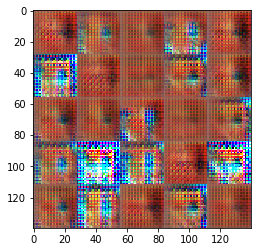

Epoch 1/1... Discriminator_loss: 0.01947847381234169 Generator_loss: 4.572020530700684
Epoch 1/1... Discriminator_loss: 0.017415236681699753 Generator_loss: 5.117618083953857
Epoch 1/1... Discriminator_loss: 0.011562664061784744 Generator_loss: 4.975337028503418
Epoch 1/1... Discriminator_loss: 0.008211769163608551 Generator_loss: 5.675242900848389
Epoch 1/1... Discriminator_loss: 0.007254892028868198 Generator_loss: 5.672912120819092
Epoch 1/1... Discriminator_loss: 0.002707613632082939 Generator_loss: 7.7668352127075195
Epoch 1/1... Discriminator_loss: 0.0037085022777318954 Generator_loss: 6.531361103057861
Epoch 1/1... Discriminator_loss: 0.005216449499130249 Generator_loss: 5.745567798614502
Epoch 1/1... Discriminator_loss: 0.006450796499848366 Generator_loss: 5.871628761291504
Epoch 1/1... Discriminator_loss: 0.0054281787015497684 Generator_loss: 5.750025749206543


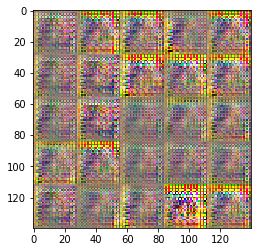

Epoch 1/1... Discriminator_loss: 0.005981880240142345 Generator_loss: 5.940230369567871
Epoch 1/1... Discriminator_loss: 0.0033453027717769146 Generator_loss: 6.210251808166504
Epoch 1/1... Discriminator_loss: 0.0032828734256327152 Generator_loss: 6.170804023742676
Epoch 1/1... Discriminator_loss: 0.0013113931054249406 Generator_loss: 7.357030391693115
Epoch 1/1... Discriminator_loss: 0.004169047810137272 Generator_loss: 6.550329208374023
Epoch 1/1... Discriminator_loss: 0.0011906481813639402 Generator_loss: 8.197751998901367
Epoch 1/1... Discriminator_loss: 0.00313478522002697 Generator_loss: 6.083627700805664
Epoch 1/1... Discriminator_loss: 0.0017661901656538248 Generator_loss: 7.49206018447876
Epoch 1/1... Discriminator_loss: 0.0037123006768524647 Generator_loss: 6.328356742858887
Epoch 1/1... Discriminator_loss: 0.004468380939215422 Generator_loss: 6.001935005187988


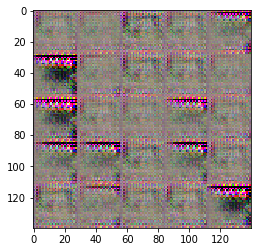

Epoch 1/1... Discriminator_loss: 0.0050770603120327 Generator_loss: 6.294469356536865
Epoch 1/1... Discriminator_loss: 0.006131860427558422 Generator_loss: 5.606534957885742
Epoch 1/1... Discriminator_loss: 0.36909717321395874 Generator_loss: 1.9845629930496216
Epoch 1/1... Discriminator_loss: 0.15270410478115082 Generator_loss: 3.42482328414917
Epoch 1/1... Discriminator_loss: 0.05812566354870796 Generator_loss: 4.0066351890563965
Epoch 1/1... Discriminator_loss: 0.0491110235452652 Generator_loss: 3.67978835105896
Epoch 1/1... Discriminator_loss: 0.06528471410274506 Generator_loss: 3.3754050731658936
Epoch 1/1... Discriminator_loss: 0.05404813960194588 Generator_loss: 5.6383771896362305
Epoch 1/1... Discriminator_loss: 0.5844516754150391 Generator_loss: 1.8127281665802002
Epoch 1/1... Discriminator_loss: 0.03311724215745926 Generator_loss: 5.094128131866455


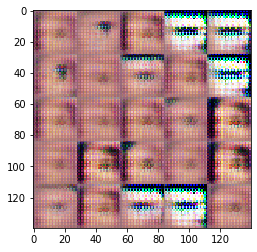

Epoch 1/1... Discriminator_loss: 0.07715091854333878 Generator_loss: 3.2049179077148438
Epoch 1/1... Discriminator_loss: 0.06400600075721741 Generator_loss: 3.812347173690796
Epoch 1/1... Discriminator_loss: 0.05468551814556122 Generator_loss: 4.002867698669434
Epoch 1/1... Discriminator_loss: 0.10003013908863068 Generator_loss: 3.584650754928589
Epoch 1/1... Discriminator_loss: 0.05411479249596596 Generator_loss: 3.773637056350708
Epoch 1/1... Discriminator_loss: 0.02973049134016037 Generator_loss: 4.71186637878418
Epoch 1/1... Discriminator_loss: 0.025516953319311142 Generator_loss: 4.7609052658081055
Epoch 1/1... Discriminator_loss: 0.060429684817790985 Generator_loss: 6.208222389221191
Epoch 1/1... Discriminator_loss: 0.15804246068000793 Generator_loss: 4.335148334503174
Epoch 1/1... Discriminator_loss: 0.21655431389808655 Generator_loss: 2.8861098289489746


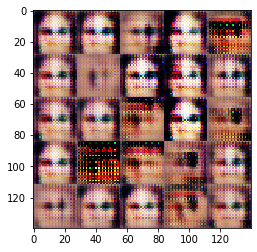

Epoch 1/1... Discriminator_loss: 0.08185537904500961 Generator_loss: 3.6951794624328613
Epoch 1/1... Discriminator_loss: 0.08222636580467224 Generator_loss: 3.611449956893921
Epoch 1/1... Discriminator_loss: 0.031244123354554176 Generator_loss: 4.906348705291748
Epoch 1/1... Discriminator_loss: 0.017091350629925728 Generator_loss: 4.799375534057617
Epoch 1/1... Discriminator_loss: 0.021351289004087448 Generator_loss: 4.6182355880737305
Epoch 1/1... Discriminator_loss: 0.03759510815143585 Generator_loss: 3.9909465312957764
Epoch 1/1... Discriminator_loss: 0.019730539992451668 Generator_loss: 5.203818321228027
Epoch 1/1... Discriminator_loss: 0.02120559848845005 Generator_loss: 4.200019836425781
Epoch 1/1... Discriminator_loss: 0.018513739109039307 Generator_loss: 4.607629776000977
Epoch 1/1... Discriminator_loss: 0.02228112891316414 Generator_loss: 4.317371368408203


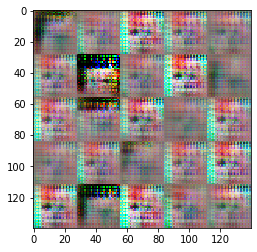

Epoch 1/1... Discriminator_loss: 0.12899447977542877 Generator_loss: 7.139670372009277
Epoch 1/1... Discriminator_loss: 0.10038448125123978 Generator_loss: 4.5656328201293945
Epoch 1/1... Discriminator_loss: 0.04828803613781929 Generator_loss: 4.352481842041016
Epoch 1/1... Discriminator_loss: 0.06138069927692413 Generator_loss: 3.8524739742279053
Epoch 1/1... Discriminator_loss: 0.157316654920578 Generator_loss: 2.9597134590148926
Epoch 1/1... Discriminator_loss: 0.2812652885913849 Generator_loss: 11.706245422363281
Epoch 1/1... Discriminator_loss: 0.02701236680150032 Generator_loss: 5.956636428833008
Epoch 1/1... Discriminator_loss: 0.013902288861572742 Generator_loss: 5.175257682800293
Epoch 1/1... Discriminator_loss: 0.02171863056719303 Generator_loss: 5.805254936218262
Epoch 1/1... Discriminator_loss: 0.009817187674343586 Generator_loss: 5.537752151489258


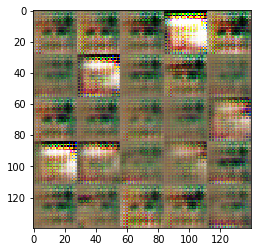

Epoch 1/1... Discriminator_loss: 0.01500106044113636 Generator_loss: 5.192868232727051
Epoch 1/1... Discriminator_loss: 0.026796415448188782 Generator_loss: 4.069026470184326
Epoch 1/1... Discriminator_loss: 0.02657754346728325 Generator_loss: 4.482914924621582
Epoch 1/1... Discriminator_loss: 0.01885334402322769 Generator_loss: 4.709158897399902
Epoch 1/1... Discriminator_loss: 0.3570973873138428 Generator_loss: 16.752880096435547
Epoch 1/1... Discriminator_loss: 0.06862698495388031 Generator_loss: 5.134736061096191
Epoch 1/1... Discriminator_loss: 0.033757343888282776 Generator_loss: 4.677850246429443
Epoch 1/1... Discriminator_loss: 0.002338303253054619 Generator_loss: 9.780515670776367
Epoch 1/1... Discriminator_loss: 0.04635090380907059 Generator_loss: 5.50859260559082
Epoch 1/1... Discriminator_loss: 0.013061193749308586 Generator_loss: 5.539815902709961


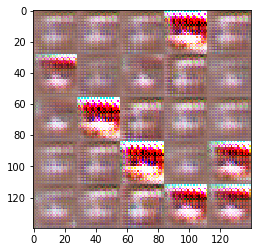

Epoch 1/1... Discriminator_loss: 0.011577405035495758 Generator_loss: 5.312549591064453
Epoch 1/1... Discriminator_loss: 0.013406729325652122 Generator_loss: 5.307014465332031
Epoch 1/1... Discriminator_loss: 0.008617479354143143 Generator_loss: 6.261281490325928
Epoch 1/1... Discriminator_loss: 0.0019521086942404509 Generator_loss: 7.246133804321289
Epoch 1/1... Discriminator_loss: 0.009848244488239288 Generator_loss: 6.306574821472168
Epoch 1/1... Discriminator_loss: 0.01854248344898224 Generator_loss: 6.142632007598877
Epoch 1/1... Discriminator_loss: 0.009850922040641308 Generator_loss: 6.570429801940918
Epoch 1/1... Discriminator_loss: 0.004800854250788689 Generator_loss: 6.529664993286133
Epoch 1/1... Discriminator_loss: 0.013179025612771511 Generator_loss: 5.638856887817383
Epoch 1/1... Discriminator_loss: 0.007858256809413433 Generator_loss: 6.862024784088135


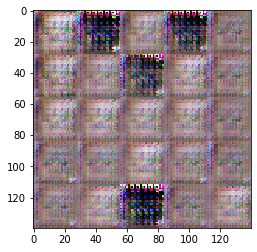

Epoch 1/1... Discriminator_loss: 0.009242633357644081 Generator_loss: 5.622198581695557
Epoch 1/1... Discriminator_loss: 2.5307424068450928 Generator_loss: 7.429222106933594
Epoch 1/1... Discriminator_loss: 0.21013759076595306 Generator_loss: 2.501589298248291
Epoch 1/1... Discriminator_loss: 0.12658195197582245 Generator_loss: 3.090287923812866
Epoch 1/1... Discriminator_loss: 0.07309538125991821 Generator_loss: 3.3071956634521484
Epoch 1/1... Discriminator_loss: 0.3160325288772583 Generator_loss: 2.232337474822998
Epoch 1/1... Discriminator_loss: 0.11762155592441559 Generator_loss: 4.222521781921387
Epoch 1/1... Discriminator_loss: 0.15366213023662567 Generator_loss: 4.584853172302246
Epoch 1/1... Discriminator_loss: 0.0435059480369091 Generator_loss: 6.203144073486328
Epoch 1/1... Discriminator_loss: 0.10081814229488373 Generator_loss: 3.8435866832733154


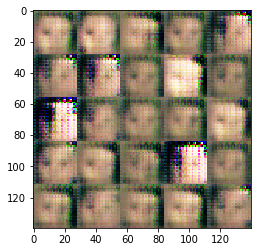

Epoch 1/1... Discriminator_loss: 0.14076337218284607 Generator_loss: 4.350727081298828
Epoch 1/1... Discriminator_loss: 0.07310909032821655 Generator_loss: 3.334895610809326
Epoch 1/1... Discriminator_loss: 0.07544421404600143 Generator_loss: 4.094869613647461
Epoch 1/1... Discriminator_loss: 0.024727677926421165 Generator_loss: 4.453717231750488
Epoch 1/1... Discriminator_loss: 0.012629739008843899 Generator_loss: 4.954739570617676
Epoch 1/1... Discriminator_loss: 0.0590653195977211 Generator_loss: 4.524443626403809
Epoch 1/1... Discriminator_loss: 0.05114387720823288 Generator_loss: 4.582825660705566
Epoch 1/1... Discriminator_loss: 0.07011011987924576 Generator_loss: 3.7797365188598633
Epoch 1/1... Discriminator_loss: 0.05017947405576706 Generator_loss: 4.138089179992676
Epoch 1/1... Discriminator_loss: 0.03569822758436203 Generator_loss: 4.56633186340332


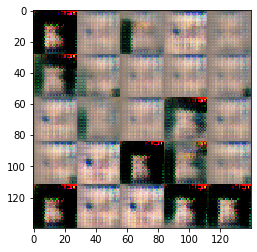

Epoch 1/1... Discriminator_loss: 0.06495537608861923 Generator_loss: 3.698997974395752
Epoch 1/1... Discriminator_loss: 0.03758472204208374 Generator_loss: 3.9402694702148438
Epoch 1/1... Discriminator_loss: 0.026012275367975235 Generator_loss: 4.288217067718506
Epoch 1/1... Discriminator_loss: 0.032076671719551086 Generator_loss: 4.586009979248047
Epoch 1/1... Discriminator_loss: 0.0521552674472332 Generator_loss: 5.297776222229004
Epoch 1/1... Discriminator_loss: 0.01393754780292511 Generator_loss: 5.467395305633545
Epoch 1/1... Discriminator_loss: 0.036623552441596985 Generator_loss: 3.8655543327331543
Epoch 1/1... Discriminator_loss: 0.02731909602880478 Generator_loss: 7.032623291015625
Epoch 1/1... Discriminator_loss: 0.018000124022364616 Generator_loss: 7.828242301940918
Epoch 1/1... Discriminator_loss: 0.10706961154937744 Generator_loss: 3.508260488510132


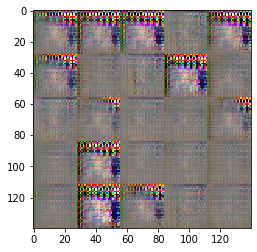

Epoch 1/1... Discriminator_loss: 0.008021939545869827 Generator_loss: 5.779103755950928
Epoch 1/1... Discriminator_loss: 0.008744836784899235 Generator_loss: 5.7725114822387695
Epoch 1/1... Discriminator_loss: 0.013226665556430817 Generator_loss: 5.34224796295166
Epoch 1/1... Discriminator_loss: 0.015763361006975174 Generator_loss: 5.098862171173096
Epoch 1/1... Discriminator_loss: 0.009848394431173801 Generator_loss: 6.059598922729492
Epoch 1/1... Discriminator_loss: 0.019278766587376595 Generator_loss: 6.052706718444824
Epoch 1/1... Discriminator_loss: 0.013885079883038998 Generator_loss: 5.079582691192627
Epoch 1/1... Discriminator_loss: 0.015229955315589905 Generator_loss: 5.081628799438477
Epoch 1/1... Discriminator_loss: 0.010048340074717999 Generator_loss: 5.768676280975342
Epoch 1/1... Discriminator_loss: 0.931378960609436 Generator_loss: 1.1594243049621582


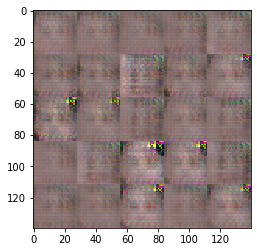

Epoch 1/1... Discriminator_loss: 0.20514070987701416 Generator_loss: 2.644753932952881
Epoch 1/1... Discriminator_loss: 0.09366139024496078 Generator_loss: 3.0273659229278564
Epoch 1/1... Discriminator_loss: 0.1065564900636673 Generator_loss: 4.0999064445495605
Epoch 1/1... Discriminator_loss: 0.04146219789981842 Generator_loss: 4.180724620819092
Epoch 1/1... Discriminator_loss: 0.05274780094623566 Generator_loss: 4.034314155578613
Epoch 1/1... Discriminator_loss: 0.028042729943990707 Generator_loss: 4.791350364685059
Epoch 1/1... Discriminator_loss: 0.025415141135454178 Generator_loss: 4.9483561515808105
Epoch 1/1... Discriminator_loss: 0.02747197449207306 Generator_loss: 4.171462059020996
Epoch 1/1... Discriminator_loss: 0.011629951186478138 Generator_loss: 7.299900054931641
Epoch 1/1... Discriminator_loss: 0.01931845024228096 Generator_loss: 4.844991683959961


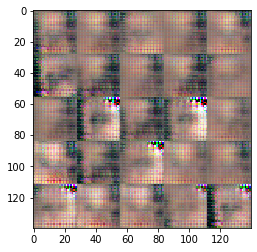

Epoch 1/1... Discriminator_loss: 0.06580985337495804 Generator_loss: 3.1780476570129395
Epoch 1/1... Discriminator_loss: 0.007084349635988474 Generator_loss: 6.308767318725586
Epoch 1/1... Discriminator_loss: 0.023100800812244415 Generator_loss: 5.020589828491211
Epoch 1/1... Discriminator_loss: 0.01686898060142994 Generator_loss: 5.9031267166137695
Epoch 1/1... Discriminator_loss: 0.016615675762295723 Generator_loss: 5.424190521240234
Epoch 1/1... Discriminator_loss: 1.2962300777435303 Generator_loss: 13.45290756225586
Epoch 1/1... Discriminator_loss: 0.05690775066614151 Generator_loss: 4.001659870147705
Epoch 1/1... Discriminator_loss: 0.05669526755809784 Generator_loss: 4.8673095703125
Epoch 1/1... Discriminator_loss: 0.05141708254814148 Generator_loss: 4.6804351806640625
Epoch 1/1... Discriminator_loss: 0.15786562860012054 Generator_loss: 3.281050682067871


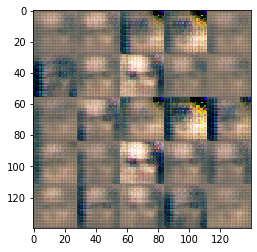

Epoch 1/1... Discriminator_loss: 0.013660822995007038 Generator_loss: 5.534490585327148
Epoch 1/1... Discriminator_loss: 0.032280467450618744 Generator_loss: 4.072874069213867
Epoch 1/1... Discriminator_loss: 0.025826912373304367 Generator_loss: 4.9079508781433105
Epoch 1/1... Discriminator_loss: 0.0725233256816864 Generator_loss: 3.6559700965881348
Epoch 1/1... Discriminator_loss: 2.621194362640381 Generator_loss: 7.890800476074219
Epoch 1/1... Discriminator_loss: 0.048780038952827454 Generator_loss: 3.7902259826660156
Epoch 1/1... Discriminator_loss: 0.0602450892329216 Generator_loss: 3.738612174987793
Epoch 1/1... Discriminator_loss: 0.025766819715499878 Generator_loss: 4.096941947937012
Epoch 1/1... Discriminator_loss: 0.03844650089740753 Generator_loss: 4.08148717880249
Epoch 1/1... Discriminator_loss: 0.020797526463866234 Generator_loss: 4.556474685668945


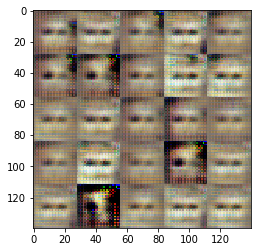

Epoch 1/1... Discriminator_loss: 0.023925384506583214 Generator_loss: 4.429421424865723
Epoch 1/1... Discriminator_loss: 0.03127420321106911 Generator_loss: 6.80149507522583
Epoch 1/1... Discriminator_loss: 0.042528558522462845 Generator_loss: 5.27068567276001
Epoch 1/1... Discriminator_loss: 0.054362617433071136 Generator_loss: 3.6422648429870605
Epoch 1/1... Discriminator_loss: 0.02849963679909706 Generator_loss: 4.176839828491211
Epoch 1/1... Discriminator_loss: 0.01621960662305355 Generator_loss: 4.91384220123291
Epoch 1/1... Discriminator_loss: 0.010334079153835773 Generator_loss: 5.429060459136963
Epoch 1/1... Discriminator_loss: 0.08512533456087112 Generator_loss: 3.051631212234497
Epoch 1/1... Discriminator_loss: 0.032031238079071045 Generator_loss: 6.741701126098633
Epoch 1/1... Discriminator_loss: 0.1402340978384018 Generator_loss: 7.29254674911499


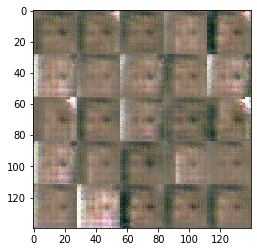

Epoch 1/1... Discriminator_loss: 12.177593231201172 Generator_loss: 21.240371704101562
Epoch 1/1... Discriminator_loss: 0.08255434781312943 Generator_loss: 3.5443384647369385
Epoch 1/1... Discriminator_loss: 0.14112691581249237 Generator_loss: 2.8300821781158447
Epoch 1/1... Discriminator_loss: 0.21553370356559753 Generator_loss: 2.6999435424804688
Epoch 1/1... Discriminator_loss: 0.07483965158462524 Generator_loss: 3.5366270542144775
Epoch 1/1... Discriminator_loss: 0.05292951315641403 Generator_loss: 3.8900976181030273
Epoch 1/1... Discriminator_loss: 0.18318215012550354 Generator_loss: 4.474291801452637
Epoch 1/1... Discriminator_loss: 0.05303722992539406 Generator_loss: 4.6286420822143555
Epoch 1/1... Discriminator_loss: 0.04953107610344887 Generator_loss: 3.898770332336426
Epoch 1/1... Discriminator_loss: 0.1549072563648224 Generator_loss: 3.330965042114258


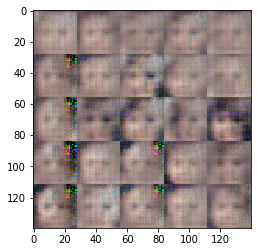

Epoch 1/1... Discriminator_loss: 0.9643552899360657 Generator_loss: 7.953064918518066
Epoch 1/1... Discriminator_loss: 6.182525634765625 Generator_loss: 10.247888565063477
Epoch 1/1... Discriminator_loss: 0.07586312294006348 Generator_loss: 4.383016586303711
Epoch 1/1... Discriminator_loss: 0.07976224273443222 Generator_loss: 3.6427764892578125
Epoch 1/1... Discriminator_loss: 0.04783015325665474 Generator_loss: 4.002950191497803
Epoch 1/1... Discriminator_loss: 0.0360916368663311 Generator_loss: 4.110146522521973
Epoch 1/1... Discriminator_loss: 0.028595341369509697 Generator_loss: 4.408129692077637
Epoch 1/1... Discriminator_loss: 0.09492900222539902 Generator_loss: 3.041006088256836
Epoch 1/1... Discriminator_loss: 0.7390676140785217 Generator_loss: 1.2028648853302002
Epoch 1/1... Discriminator_loss: 0.04608405753970146 Generator_loss: 4.931492805480957


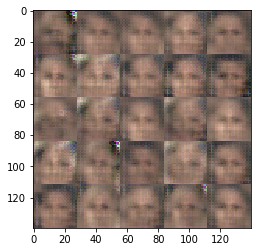

Epoch 1/1... Discriminator_loss: 0.05268865451216698 Generator_loss: 4.703797817230225
Epoch 1/1... Discriminator_loss: 0.029331307858228683 Generator_loss: 5.697644233703613
Epoch 1/1... Discriminator_loss: 0.022797368466854095 Generator_loss: 6.735589027404785
Epoch 1/1... Discriminator_loss: 0.014238523319363594 Generator_loss: 5.403176307678223
Epoch 1/1... Discriminator_loss: 0.18013986945152283 Generator_loss: 8.72663402557373
Epoch 1/1... Discriminator_loss: 0.06772571802139282 Generator_loss: 4.566389083862305
Epoch 1/1... Discriminator_loss: 0.07717084884643555 Generator_loss: 5.280167102813721
Epoch 1/1... Discriminator_loss: 0.008919279091060162 Generator_loss: 6.4206414222717285
Epoch 1/1... Discriminator_loss: 0.015114751644432545 Generator_loss: 5.800828456878662
Epoch 1/1... Discriminator_loss: 0.04952443391084671 Generator_loss: 5.382380485534668


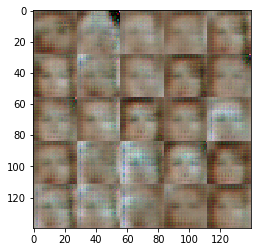

Epoch 1/1... Discriminator_loss: 0.04255019128322601 Generator_loss: 5.134910583496094
Epoch 1/1... Discriminator_loss: 0.345863938331604 Generator_loss: 6.0063090324401855
Epoch 1/1... Discriminator_loss: 0.05936087667942047 Generator_loss: 4.147025108337402
Epoch 1/1... Discriminator_loss: 0.04518929496407509 Generator_loss: 3.8372673988342285
Epoch 1/1... Discriminator_loss: 0.042312026023864746 Generator_loss: 4.19682502746582
Epoch 1/1... Discriminator_loss: 0.6610128879547119 Generator_loss: 3.49043345451355
Epoch 1/1... Discriminator_loss: 0.10955129563808441 Generator_loss: 3.6763906478881836
Epoch 1/1... Discriminator_loss: 0.11203199625015259 Generator_loss: 3.074685573577881
Epoch 1/1... Discriminator_loss: 0.19458350539207458 Generator_loss: 3.9224929809570312
Epoch 1/1... Discriminator_loss: 0.10703295469284058 Generator_loss: 3.2484383583068848


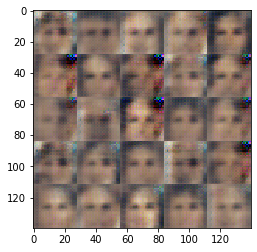

Epoch 1/1... Discriminator_loss: 0.1288025826215744 Generator_loss: 3.0257740020751953
Epoch 1/1... Discriminator_loss: 0.010847249999642372 Generator_loss: 7.1496806144714355
Epoch 1/1... Discriminator_loss: 0.05080197751522064 Generator_loss: 3.7780323028564453
Epoch 1/1... Discriminator_loss: 0.02868214063346386 Generator_loss: 4.223342418670654
Epoch 1/1... Discriminator_loss: 0.020244672894477844 Generator_loss: 4.9086408615112305
Epoch 1/1... Discriminator_loss: 0.013114472851157188 Generator_loss: 4.997076034545898
Epoch 1/1... Discriminator_loss: 0.02000400610268116 Generator_loss: 4.542699813842773
Epoch 1/1... Discriminator_loss: 0.058814845979213715 Generator_loss: 3.4242122173309326
Epoch 1/1... Discriminator_loss: 0.03773029148578644 Generator_loss: 4.170895576477051
Epoch 1/1... Discriminator_loss: 0.03914261236786842 Generator_loss: 11.14501667022705


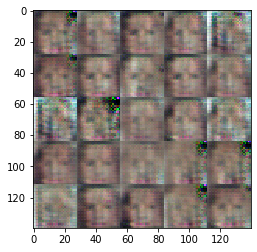

Epoch 1/1... Discriminator_loss: 0.07056835293769836 Generator_loss: 4.480840682983398
Epoch 1/1... Discriminator_loss: 0.07989713549613953 Generator_loss: 4.433437347412109
Epoch 1/1... Discriminator_loss: 0.11405074596405029 Generator_loss: 3.531525135040283
Epoch 1/1... Discriminator_loss: 0.11126424372196198 Generator_loss: 2.9270105361938477
Epoch 1/1... Discriminator_loss: 0.14912599325180054 Generator_loss: 4.19377326965332
Epoch 1/1... Discriminator_loss: 0.06797619163990021 Generator_loss: 4.1351776123046875
Epoch 1/1... Discriminator_loss: 0.1370006501674652 Generator_loss: 2.767897605895996
Epoch 1/1... Discriminator_loss: 0.071358323097229 Generator_loss: 3.862834930419922
Epoch 1/1... Discriminator_loss: 0.043630555272102356 Generator_loss: 4.414314270019531
Epoch 1/1... Discriminator_loss: 0.05328689143061638 Generator_loss: 3.8910346031188965


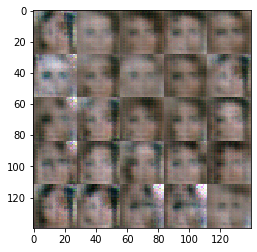

Epoch 1/1... Discriminator_loss: 0.24459290504455566 Generator_loss: 2.8958652019500732
Epoch 1/1... Discriminator_loss: 0.21672402322292328 Generator_loss: 2.5621538162231445
Epoch 1/1... Discriminator_loss: 0.13161860406398773 Generator_loss: 3.1091699600219727
Epoch 1/1... Discriminator_loss: 0.08231602609157562 Generator_loss: 3.914741039276123
Epoch 1/1... Discriminator_loss: 0.0879807248711586 Generator_loss: 3.9274253845214844
Epoch 1/1... Discriminator_loss: 0.12263824045658112 Generator_loss: 4.405522346496582
Epoch 1/1... Discriminator_loss: 0.14814606308937073 Generator_loss: 5.995963096618652
Epoch 1/1... Discriminator_loss: 0.06400257349014282 Generator_loss: 4.906972885131836
Epoch 1/1... Discriminator_loss: 0.08200743049383163 Generator_loss: 5.295845031738281
Epoch 1/1... Discriminator_loss: 0.1322365403175354 Generator_loss: 9.718250274658203


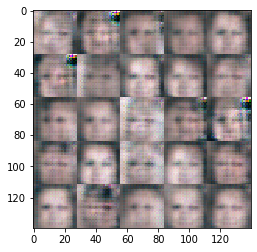

Epoch 1/1... Discriminator_loss: 0.1194070503115654 Generator_loss: 3.332756280899048
Epoch 1/1... Discriminator_loss: 0.03371036425232887 Generator_loss: 4.99637508392334
Epoch 1/1... Discriminator_loss: 0.0678558498620987 Generator_loss: 3.5676326751708984
Epoch 1/1... Discriminator_loss: 0.1737169474363327 Generator_loss: 2.929058074951172
Epoch 1/1... Discriminator_loss: 0.16764023900032043 Generator_loss: 2.797490358352661
Epoch 1/1... Discriminator_loss: 0.08202368021011353 Generator_loss: 3.299863338470459
Epoch 1/1... Discriminator_loss: 0.05240795016288757 Generator_loss: 3.862412691116333
Epoch 1/1... Discriminator_loss: 0.04135715588927269 Generator_loss: 6.383271217346191
Epoch 1/1... Discriminator_loss: 0.05406517907977104 Generator_loss: 4.6488847732543945
Epoch 1/1... Discriminator_loss: 0.07193279266357422 Generator_loss: 4.061422348022461


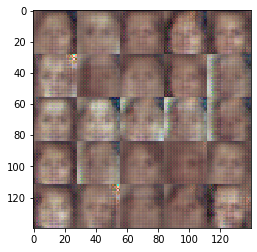

Epoch 1/1... Discriminator_loss: 0.07508619874715805 Generator_loss: 9.618391036987305
Epoch 1/1... Discriminator_loss: 0.027710292488336563 Generator_loss: 4.917268753051758
Epoch 1/1... Discriminator_loss: 0.036614399403333664 Generator_loss: 4.068366050720215
Epoch 1/1... Discriminator_loss: 0.0378979817032814 Generator_loss: 4.220688343048096
Epoch 1/1... Discriminator_loss: 0.010761450976133347 Generator_loss: 5.915558815002441
Epoch 1/1... Discriminator_loss: 1.7885738611221313 Generator_loss: 10.088502883911133


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.